# From .FIT -> .csv

## How .FIT fiels are structured

In [1]:
from garmin_fit_sdk import Decoder, Stream
import pandas as pd
import datetime
from tqdm import tqdm

In [2]:
FIT_FILE_LOCATION = "/home/kuba/Desktop/2025-05-29-12-46-14.fit"
FILE_NAME = 'test_recording'
CSV_SAVE_LOCATION = f"~/Desktop/{FILE_NAME}.csv"

In [3]:
stream = Stream.from_file(FIT_FILE_LOCATION)
decoder = Decoder(stream)
messages, errors = decoder.read()

In [4]:
print('errors: ',errors)

errors:  []


In [5]:
print('We have ',len(messages['accelerometer_data_mesgs']),' groups of data')
print('Each group has ',len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points')
print('In total we have',len(messages['accelerometer_data_mesgs']) * len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points in the whole fit file')

We have  28  groups of data
Each group has  25 sampled points
In total we have 700 sampled points in the whole fit file


In [6]:
print('We have ',len(messages['gyroscope_data_mesgs']),' groups of data')
print('Each group has ',len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points')
print('In total we have',len(messages['gyroscope_data_mesgs']) * len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points in the whole fit file')

We have  28  groups of data
Each group has  25 sampled points
In total we have 700 sampled points in the whole fit file


In [7]:
#create the dataframeß
df = pd.DataFrame(columns=['timestamp', 'x_accel', 'y_accel', 'z_accel', 'x_gyro', 'y_gyro', 'z_gyro'])

In [8]:
# add a group to the dataframe
def add_to_df(df, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro, timestamp, timestamp_ms, sample_time_offset):
    if not (len(x_accel) == len(y_accel) == len(z_accel) == len(sample_time_offset)) or not (len(x_gyro) == len(y_gyro) == len(z_gyro) == len(sample_time_offset)) or not (len(x_accel) == len(x_gyro)):
        raise ValueError("All input lists must have the same length")

    
    precise_base_timestamp = timestamp.replace(microsecond=timestamp_ms*1000)
    
    start_idx = len(df)
    
    for i in range(len(x_gyro)):
        sample_timestamp = precise_base_timestamp + datetime.timedelta(milliseconds=sample_time_offset[i])
        df.loc[start_idx + i] = [sample_timestamp, x_accel[i], y_accel[i], z_accel[i], x_gyro[i], y_gyro[i], z_gyro[i]]
    
    return df

In [9]:
# iterate over all groups to add to the df
for group in tqdm(range(len(messages['accelerometer_data_mesgs']))):
    df = add_to_df(df, 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_x'], 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_y'], 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_z'],

                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_x'], 
                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_y'], 
                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_z'],
                   
                   messages['accelerometer_data_mesgs'][group]['timestamp'], 
                   messages['accelerometer_data_mesgs'][group]['timestamp_ms'], 
                   messages['accelerometer_data_mesgs'][group]['sample_time_offset'])

100%|██████████| 28/28 [00:03<00:00,  7.81it/s]


In [10]:
df

,timestamp,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro
0,2025-05-29 16:46:13.189000+00:00,-298.098419,-704.850647,-692.057007,-4.882744,-1.668252,-0.867399
1,2025-05-29 16:46:13.208000+00:00,-162.757385,-739.114075,-597.901367,-8.802745,-7.478252,-4.367399
2,2025-05-29 16:46:13.216000+00:00,-271.425354,-745.776367,-608.690002,-8.417745,-2.928252,-4.402399
3,2025-05-29 16:46:13.228000+00:00,-263.522247,-754.342224,-694.999390,24.062256,2.916748,4.627601
4,2025-05-29 16:46:13.237000+00:00,-174.612076,-710.561279,-846.040771,22.802256,-19.238253,5.922601
...,...,...,...,...,...,...,...
695,2025-05-29 16:46:20.140000+00:00,-10.622223,-201.369476,-832.309692,-73.657745,-83.673248,-54.417400
696,2025-05-29 16:46:20.150000+00:00,-18.525349,-138.553299,-848.002319,-85.557747,-104.568253,-66.562393
697,2025-05-29 16:46:20.160000+00:00,-29.392145,-101.434647,-863.694946,-94.412750,-121.718254,-69.362396
698,2025-05-29 16:46:20.170000+00:00,10.123480,-127.132179,-923.523010,-92.907745,-131.063248,-66.037399


Lets take a look at it

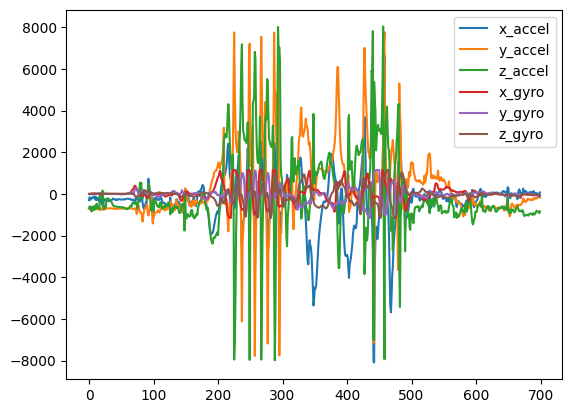

In [11]:
import matplotlib.pyplot as plt
plt.plot(df['x_accel'], label='x_accel')
plt.plot(df['y_accel'], label='y_accel')
plt.plot(df['z_accel'], label='z_accel')

plt.plot(df['x_gyro'], label='x_gyro')
plt.plot(df['y_gyro'], label='y_gyro')
plt.plot(df['z_gyro'], label='z_gyro')
plt.legend()
plt.show()


Now lests save it

In [12]:
df.to_csv(CSV_SAVE_LOCATION, index=False)